**Diagnosis of Diabetic Retinopathy through Machine Learning-Based Image Processing**

Kelompok 7 LK01

*   Orsino Jerrell Bruinier - 2602065540
*   Talethia Hayfa Syukur - 2602067016

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root= '/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset'

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Validation', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy Dataset/Tester', transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
class_name = train_dataset.classes
class_name

['DR', 'No_DR']

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
num_classes = 2  
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features 
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        if isinstance(outputs, tuple):  
            outputs, aux_outputs = outputs
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({'loss': running_loss / ((progress_bar.n + 1) * batch_size)})
        progress_bar.update()

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if isinstance(outputs, tuple): 
                outputs, aux_outputs = outputs
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.7f}, '
          f'Val Loss: {val_loss:.7f}, '
          f'Val Acc: {val_accuracy:.7f}')



model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.7f}')


Epoch [1/10], Train Loss: 0.4442799, Val Loss: 0.1330176, Val Acc: 0.9585687


Epoch [2/10], Train Loss: 0.1823873, Val Loss: 0.1320835, Val Acc: 0.9642185


Epoch [3/10], Train Loss: 0.1192026, Val Loss: 0.1458890, Val Acc: 0.9604520


Epoch [4/10], Train Loss: 0.1112681, Val Loss: 0.1903167, Val Acc: 0.9472693


Epoch [5/10], Train Loss: 0.0896550, Val Loss: 0.1120046, Val Acc: 0.9661017


Epoch [6/10], Train Loss: 0.0509606, Val Loss: 0.1385121, Val Acc: 0.9679849


Epoch [7/10], Train Loss: 0.0822052, Val Loss: 0.4847738, Val Acc: 0.9077213


Epoch [8/10], Train Loss: 0.1068513, Val Loss: 0.1728641, Val Acc: 0.9566855


Epoch [9/10], Train Loss: 0.0565538, Val Loss: 0.1095127, Val Acc: 0.9661017


Epoch [10/10], Train Loss: 0.0195324, Val Loss: 0.1569612, Val Acc: 0.9661017
Test Accuracy: 0.9826840


In [20]:
predicted

tensor([1, 0, 1, 0, 1, 0, 1], device='cuda:0')

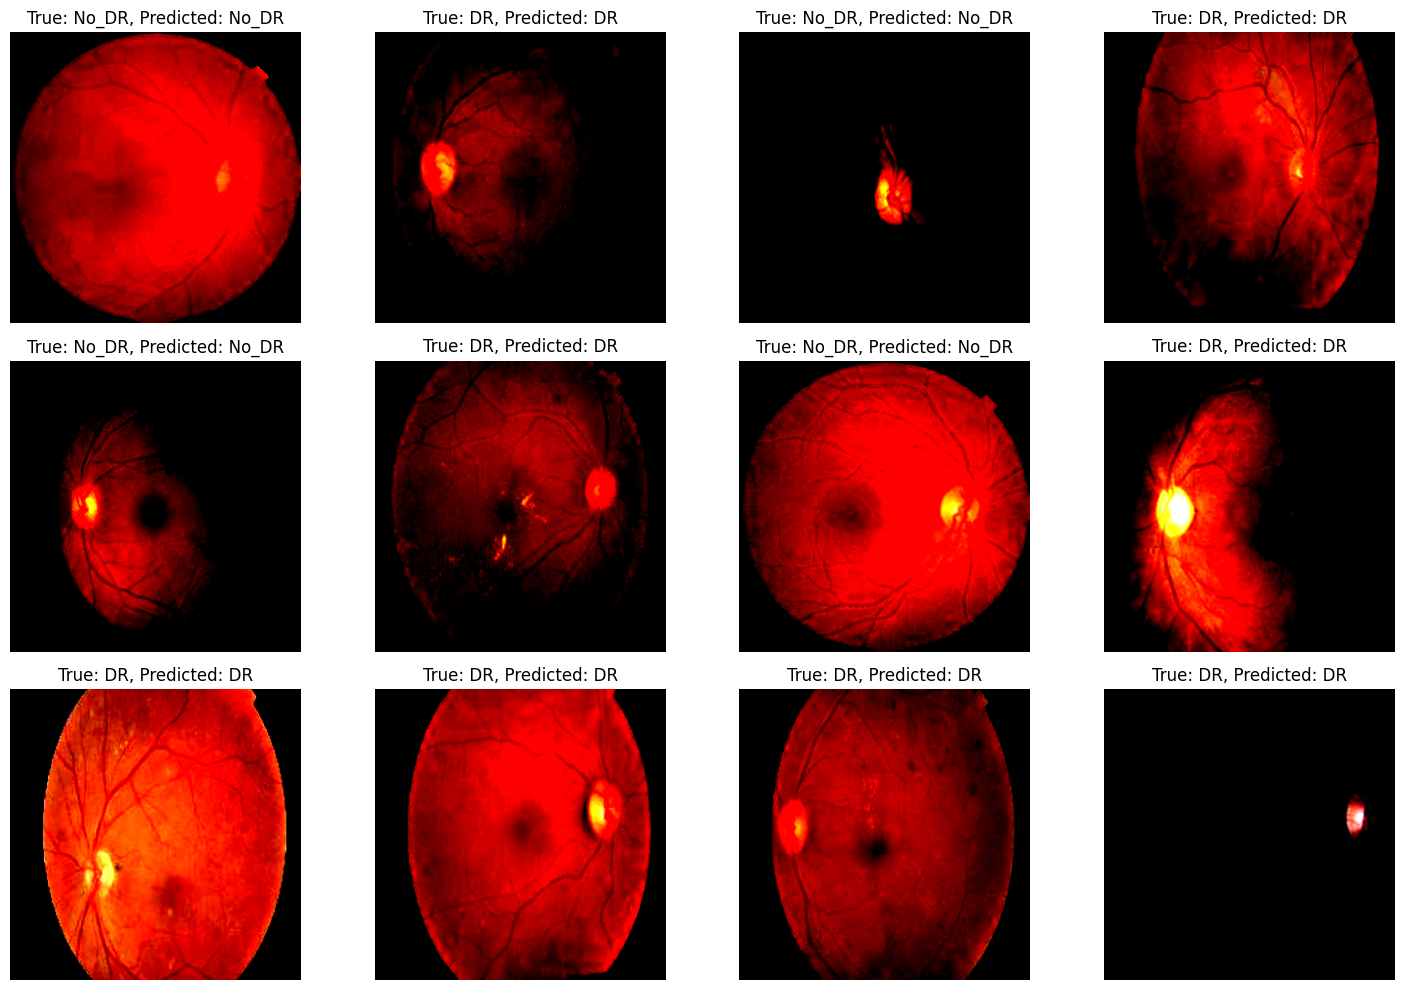

In [21]:
model.eval()

images, labels = next(iter(test_loader))

images, labels = images.to(device), labels.to(device)

outputs = model(images)

_, predicted = torch.max(outputs, 1)

images = images.cpu().numpy()

predicted_np = predicted.cpu().numpy()

true_labels_np = labels.cpu().numpy()

num_samples_to_show = 12

indices = np.random.choice(batch_size, num_samples_to_show, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i, idx in enumerate(indices):
    ax = axes[i // 4, i % 4] 
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(f'True: {class_name[true_labels_np[idx]]}, Predicted: {class_name[predicted_np[idx]]}')
    ax.axis('off')

# Hide empty subplots
for i in range(num_samples_to_show, 12):
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()
plt.show()

Test Accuracy: 0.9826840


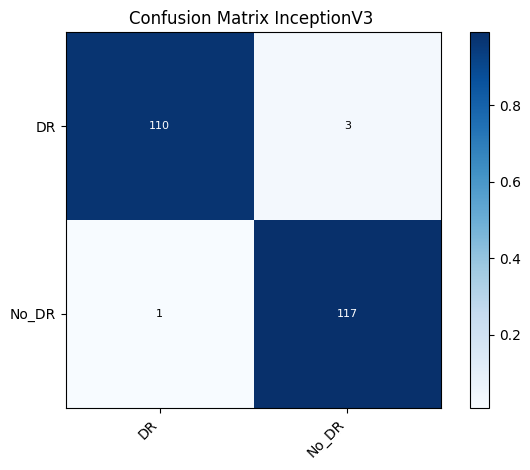

In [22]:
model.eval()
test_correct = 0
test_total = 0
all_predicted = []
all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.7f}')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_true, all_predicted)

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, cmap='Blues')

classes = class_name 
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticklabels(classes)
ax.set_title('Confusion Matrix InceptionV3 ')

fmt = 'd'  
thresh = cm_norm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
             fontsize=8, color='white' if cm_norm[i, j] > thresh else 'black')

fig.colorbar(im)
plt.tight_layout()
plt.show()

In [23]:
model.eval()
test_correct = 0
test_total = 0
all_predicted = []
all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

 
        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.7f}')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_true, all_predicted)

tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)

specificity = tn / (tn + fp)

print('Confusion Matrix InceptionV3:')
print(cm)
print(f'Test Accuracy: {test_accuracy:.7f}')
print(f'Sensitivity (Recall): {sensitivity:.7f}')
print(f'Specificity: {specificity:.7f}')

Test Accuracy: 0.9826840
Confusion Matrix DenseNet-121:
[[110   3]
 [  1 117]]
Test Accuracy: 0.9826840
Sensitivity (Recall): 0.9915254
Specificity: 0.9734513
